In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

### Simple repression

In [6]:
# LacI binding site
rep_site = 'AATTGTGAGCGGATAACAATT'

In [7]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [8]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [17]:
n_NS = len(genome)
n_p = 4600
l_n_r = np.arange(0, 51)
ep_wt = -5
er_wt = -15

l_range_simrep = []
for n_r in l_n_r:
    df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site],
                            *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                            scaling_factor=10**6)
    
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    upper_bound = np.mean(mu_data)
    nbins = 2
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))

    rv = {}
    rv['architecture'] = 'simple_repression'
    rv['tf_copy_number'] = n_r
    rv['dynamic_range'] = np.max(df['norm_ct_1']) - np.min(df['norm_ct_1'])
    rv['maximum_mi'] = np.max(footprint)
    l_range_simrep.append(rv)

# convert list of dictionaries to dataframe
df_range_simrep = pd.DataFrame(l_range_simrep)

Text(0, 0.5, 'Maximum mutual information')

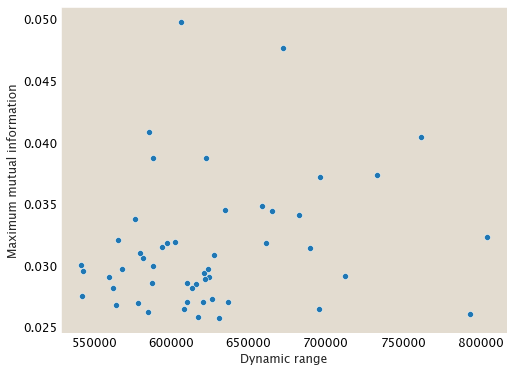

In [23]:
# scatter plot of dynamic range vs maximum mutual information
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df_range_simrep, x='dynamic_range', y='maximum_mi', ax=ax)
ax.set_xlabel('Dynamic range')
ax.set_ylabel('Maximum mutual information')

### Simple activation

In [24]:
# CRP binding site
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

In [25]:
# energy matrix obtained from Fig 3. of Kinney et al., 2010 (https://www.pnas.org/doi/full/10.1073/pnas.1004290107)
# elements expressed in kcal/mol (1 kcal/mol = 1.62kbT)

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

In [27]:
# only increasing strength of activator-promoter binding

n_NS = len(genome)
n_p = 4600
ep_wt = -7
ea_wt = -15
e_ap = -10
l_n_a = np.arange(0, 51)

l_range_simact = []
for n_a in l_n_a:
    df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                            *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap],
                            scaling_factor=10**6)
    
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    upper_bound = np.mean(mu_data)
    nbins = 2
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))

    rv = {}
    rv['architecture'] = 'simple_repression'
    rv['tf_copy_number'] = n_r
    rv['dynamic_range'] = np.max(df['norm_ct_1']) - np.min(df['norm_ct_1'])
    rv['maximum_mi'] = np.max(footprint)
    l_range_simact.append(rv)

# convert list of dictionaries to dataframe
df_range_simact = pd.DataFrame(l_range_simact)

### Double repression

In [28]:
rep1_site = promoter[(115-50):(115-40)]
rep2_site = promoter[(115+15):(115+25)]
r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

In [29]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -15, -15
e_int = -10
n_p, n_r2 = 4600, 15
l_n_r1 = np.arange(0, 51)

l_range_doublerep_AND = []
for n_r1 in l_n_r1:
    df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)
    
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    upper_bound = np.mean(mu_data)
    nbins = 2
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))

    rv = {}
    rv['architecture'] = 'simple_repression'
    rv['tf_copy_number'] = n_r
    rv['dynamic_range'] = np.max(df['norm_ct_1']) - np.min(df['norm_ct_1'])
    rv['maximum_mi'] = np.max(footprint)
    l_range_doublerep_AND.append(rv)

# convert list of dictionaries to dataframe
df_range_doublerep_AND = pd.DataFrame(l_range_doublerep_AND)

In [32]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -15, -15
e_int = -10
n_p, n_r2 = 4600, 15
l_n_r1 = np.arange(0, 51)

l_range_doublerep_OR = []
for n_r1 in l_n_r1:
    df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)
    
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    upper_bound = np.mean(mu_data)
    nbins = 2
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))

    rv = {}
    rv['architecture'] = 'double repression, OR gate'
    rv['tf_copy_number'] = n_r
    rv['dynamic_range'] = np.max(df['norm_ct_1']) - np.min(df['norm_ct_1'])
    rv['maximum_mi'] = np.max(footprint)
    l_range_doublerep_OR.append(rv)

# convert list of dictionaries to dataframe
df_range_doublerep_OR = pd.DataFrame(l_range_doublerep_AND)

### Double activation

In [33]:
act1_site = promoter[(115 - 110 + 15):(115 - 110 + 25)]
act2_site = promoter[(115 - 110 + 35):(115 - 110 + 45)]
a1_emat = tregs.simulate.generate_emap(act1_site, fixed=True, fixed_value=1)
a2_emat = tregs.simulate.generate_emap(act2_site, fixed=True, fixed_value=1)

In [34]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -5, -5
e_int_pa1, e_int_pa2, e_int_a1a2 = -5, -5, -5
n_p, n_a1, n_a2 = 4600, 50, 50

l_range_doubleact_AND = []
for n_r1 in l_n_r1:
    df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)
    
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    upper_bound = np.mean(mu_data)
    nbins = 2
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))

    rv = {}
    rv['architecture'] = 'double activation, AND gate'
    rv['tf_copy_number'] = n_r
    rv['dynamic_range'] = np.max(df['norm_ct_1']) - np.min(df['norm_ct_1'])
    rv['maximum_mi'] = np.max(footprint)
    l_range_doubleact_AND.append(rv)

# convert list of dictionaries to dataframe
df_range_doubleact_AND = pd.DataFrame(l_range_doubleact_AND)

In [ ]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -5, -5
e_int_pa1, e_int_pa2, e_int_a1a2 = -5, -5, -5
n_p, n_a1, n_a2 = 4600, 50, 50

l_range_doubleact_OR = []
for n_r1 in l_n_r1:
    df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)
    
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    upper_bound = np.mean(mu_data)
    nbins = 2
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))

    rv = {}
    rv['architecture'] = 'double activation, AND gate'
    rv['tf_copy_number'] = n_r
    rv['dynamic_range'] = np.max(df['norm_ct_1']) - np.min(df['norm_ct_1'])
    rv['maximum_mi'] = np.max(footprint)
    l_range_doubleact_AND.append(rv)

# convert list of dictionaries to dataframe
df_range_doubleact_OR = pd.DataFrame(l_range_doubleact_AND)

**Notes:**
- binding energy for RNAP should be lower when there is double activation
- full operator but only mutate one of them -- would we be able to deduce looping

In [35]:
# concatenate dynamic range dataframes
df_range = pd.concat([df_range_simrep, df_range_simact, df_range_doublerep_AND, df_range_doublerep_OR, df_range_doubleact_AND])
df_range

,architecture,tf_copy_number,dynamic_range,maximum_mi
0,simple_repression,0,606347.451232,0.049777
1,simple_repression,1,672210.360284,0.047635
2,simple_repression,2,761750.070141,0.040405
3,simple_repression,3,585545.529387,0.040857
4,simple_repression,4,622439.583371,0.038754
...,...,...,...,...
46,simple_repression,50,10.530212,0.013324
47,simple_repression,50,6.048524,0.014702
48,simple_repression,50,9.110119,0.014930
49,simple_repression,50,17.470847,0.013511


Text(0, 0.5, 'Maximum mutual information')

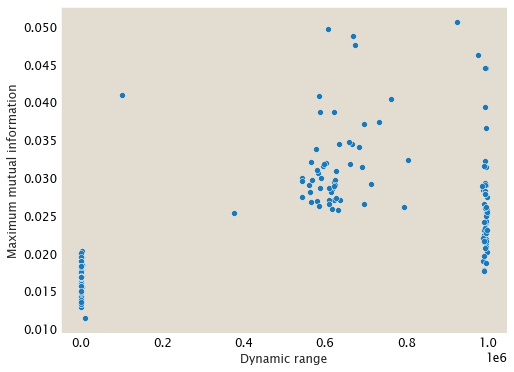

In [37]:
# plot dynamic range vs maximum mutual information
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df_range, x='dynamic_range', y='maximum_mi', ax=ax)
ax.set_xlabel('Dynamic range')
ax.set_ylabel('Maximum mutual information')

### Repression-activation

In [23]:
n_NS = len(genome)
ep_wt, er_wt, ea_wt = -2, -13, -13
e_int = -10
n_p, n_r, n_a = 4600, 50, 50

df = tregs.simulate.sim(promoter, tregs.simulate.repact_pbound, [rnap_site, rep_site, crp_site],
                        *[n_NS, n_p, n_r, n_a, rnap_emat, rep_emat, crp_emat, ep_wt, er_wt, ea_wt, e_int], scaling_factor=10*6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP'), (2, 17, 'R', 'LacI')]

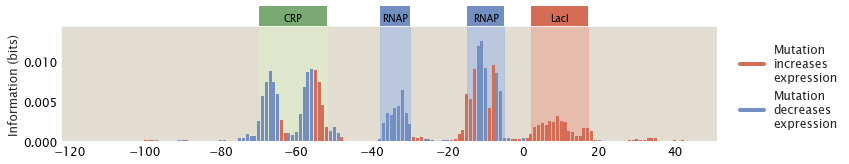

In [24]:
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=2, annotate_stn=False,
                               outfile='../../manuscript/figures/plots/fig3/repact.png')